
# Linear Regression from Scratch

This notebook implements **Linear Regression** using **Batch Gradient Descent**, **Stochastic Gradient Descent** and **Normal Equation** methods, 
as taught in **Stanford's CS229: Machine Learning (Autumn 2018, Lecture 2)** by Andrew Ng.

It includes:
- Feature normalization using Z-score
- Cost function visualization
- Optimization using gradient descent
- Closed-form solution using the normal equation
- 3D plots and performance comparison

> 📘 This is part of a broader `ml-from-scratch` project implementing ML algorithms using only NumPy and pandas for educational purposes.


In [1]:
import pickle
import numpy as np
from typing import Union,List
import pandas as pd
from numpy import ndarray
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
class LinearRegression:
    def __init__(self):
        self.x_mean: ndarray = None
        self.x_std: ndarray = None
        self.y_mean: ndarray = None
        self.y_std: ndarray = None
        self.Theta: ndarray = None  # From Normal Equation
        self.theta: ndarray = None  # From Batch GD
        self.thetaSGD: ndarray = None  # From SGD
        self.x_norm: ndarray = None
        self.y_norm: ndarray = None
        self.is_norm: bool = False

    def normalize(self, x_train: ndarray, y_train: ndarray, add_bias=True):
        self.x_mean = x_train.mean(axis=0)
        self.x_std = x_train.std(axis=0)
        self.y_mean = y_train.mean(axis=0)
        self.y_std = y_train.std(axis=0)

        self.x_std[self.x_std == 0] = 1
        self.y_std[self.y_std == 0] = 1

        self.x_norm = (x_train - self.x_mean) / self.x_std
        self.y_norm = (y_train - self.y_mean) / self.y_std

        if add_bias:
            x_0 = np.ones((self.x_norm.shape[0], 1))
            self.x_norm = np.hstack((x_0, self.x_norm))

        self.is_norm = True
        return self.x_norm, self.y_norm, *self.x_norm.shape, self.x_mean, self.x_std, self.y_mean, self.y_std

    @staticmethod
    def h(x: ndarray, theta: ndarray) -> ndarray:
        return np.dot(x, theta)

    @staticmethod
    def J(x: ndarray, y: ndarray, theta: ndarray) -> float:
        m = x.shape[0]
        error = LinearRegression.h(x, theta) - y
        return (1 / (2 * m)) * np.sum(np.square(error))

    def fit(self, x_train: ndarray, y_train: ndarray, add_bias: bool = True) -> ndarray:
        if not self.is_norm:
            self.normalize(x_train, y_train, add_bias)
        XtX_inv = np.linalg.pinv(self.x_norm.T @ self.x_norm)
        Xty = self.x_norm.T @ self.y_norm
        theta = XtX_inv @ Xty
        loss = self.J(self.x_norm, self.y_norm, theta)
        print(f"[Normal Eq] Loss = {loss}")
        self.Theta = theta
        return theta

    def trainSGD(self, x_train: ndarray, y_train: ndarray, alpha: float, theta: ndarray = None, epoch: int = 100, add_bias: bool = True) -> ndarray:
        if not self.is_norm:
            self.normalize(x_train, y_train, add_bias)
        if theta is None:
            theta = np.zeros((self.x_norm.shape[1], 1))
        m = self.x_norm.shape[0]
        losses = []

        for _ in range(epoch):
            for i in range(m):
                xi = self.x_norm[i].reshape(1, -1)  # (1, n)
                yi = self.y_norm[i]
                error = LinearRegression.h(xi, theta) - yi
                grad = xi.T * error
                theta -= alpha * grad
            losses.append(self.J(self.x_norm, self.y_norm, theta))

        self.thetaSGD = theta
        print(f"[SGD] Final Loss = {self.J(self.x_norm, self.y_norm, theta)}")

        plt.plot(range(1, epoch + 1), losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.title("SGD Loss Curve")
        plt.show()

        return theta

    def train(self, x_train: ndarray, y_train: ndarray, alpha: float, theta: ndarray = None, epoch: int = 100, add_bias: bool = True) -> ndarray:
        if not self.is_norm:
            self.normalize(x_train, y_train, add_bias)
        if theta is None:
            theta = np.zeros((self.x_norm.shape[1], 1))
        m = self.x_norm.shape[0]
        losses = []

        for _ in range(epoch):
            error = LinearRegression.h(self.x_norm, theta) - self.y_norm
            grad = (1 / m) * self.x_norm.T @ error
            theta -= alpha * grad
            losses.append(self.J(self.x_norm, self.y_norm, theta))

        self.theta = theta
        print(f"[Batch GD] Final Loss = {self.J(self.x_norm, self.y_norm, theta)}")

        plt.plot(range(1, epoch + 1), losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.title("Batch GD Loss Curve")
        plt.show()

        return theta

    def save(self, filepath) -> None:
        data = {
            "x_mean": self.x_mean,
            "x_std": self.x_std,
            "y_mean": self.y_mean,
            "y_std": self.y_std,
            "theta": self.theta,
            "Theta": self.Theta,
            "thetaSGD": self.thetaSGD
        }
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)

    class Loader:
        def __init__(self, path: str):
            with open(path, 'rb') as f:
                data = pickle.load(f)

            self.x_mean = data.get("x_mean")
            self.x_std = data.get("x_std")
            self.y_mean = data.get("y_mean")
            self.y_std = data.get("y_std")
            self.theta = data.get("theta")
            self.Theta = data.get("Theta")
            self.thetaSGD = data.get("thetaSGD")

        def predict(
            self,
            X_input: Union[List[float], List[List[float]]],
            use_theta: bool = False,
            use_Theta: bool = False,
            use_thetaSGD: bool = False,
            add_bias: bool = False
        ) -> ndarray:
            X_input = np.array(X_input, dtype=float)
            if X_input.ndim == 1:
                X_input = X_input.reshape(1, -1)

            X_norm = (X_input - self.x_mean) / self.x_std

            if add_bias:
                if not np.allclose(X_norm[:, 0], 1.0):
                    X_norm = np.hstack((np.ones((X_norm.shape[0], 1)), X_norm))

            theta_used = None
            if use_theta and self.theta is not None:
                theta_used = self.theta
                print("Using `theta` (Batch GD)")
            elif use_Theta and self.Theta is not None:
                theta_used = self.Theta
                print("Using `Theta` (Normal Eq)")
            elif use_thetaSGD and self.thetaSGD is not None:
                theta_used = self.thetaSGD
                print("Using `thetaSGD` (SGD)")
            elif self.theta is not None:
                theta_used = self.theta
                print("Defaulting to `theta` (Batch GD)")
            else:
                raise ValueError("No valid theta found for prediction.")

            y_pred_norm = LinearRegression.h(X_norm, theta_used)
            return y_pred_norm * self.y_std + self.y_mean


In [4]:
data = pd.read_csv("./data/Data.txt", header=None,
                   names=["Size_sqft", "Bedrooms", "Price_USD"])
print(data.isnull().sum())
data.head()

Size_sqft    0
Bedrooms     0
Price_USD    0
dtype: int64


,Size_sqft,Bedrooms,Price_USD
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


In [5]:
x_train = data[["Size_sqft", "Bedrooms"]].values
y_train = data[["Price_USD"]].values

[Normal Eq] Loss = 0.13352749098554287
[Batch GD] Final Loss = 0.1335420409574586


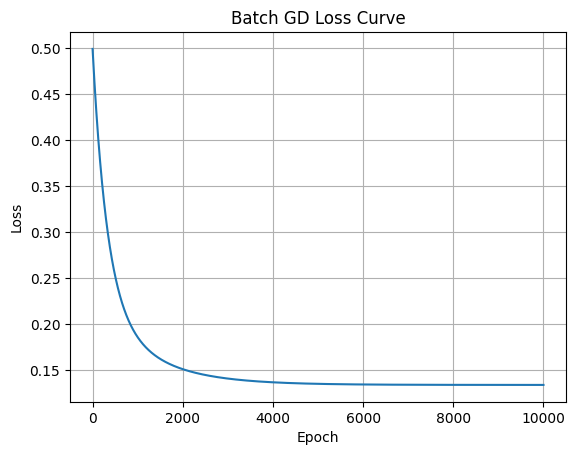

array([[-8.32597880e-17],
       [ 8.79015645e-01],
       [-4.74286144e-02]])

In [6]:
model = LinearRegression()

model.fit(x_train,y_train,add_bias=True)
model.train(x_train,y_train, 0.001, epoch= 10000, add_bias= True)

[SGD] Final Loss = 0.13356081437283907


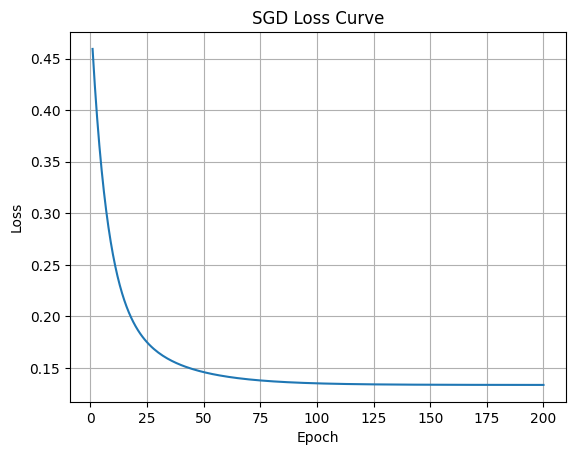

In [17]:
model.trainSGD(x_train,y_train, 0.001, epoch= 200, add_bias= True)
model.save("SGDparams.pkl")

In [11]:
inference = LinearRegression.Loader("params.pkl")
y_pred = inference.predict([1500, 3],use_Theta=True , add_bias=True)
print("Predicted:", y_pred[0])

Using `Theta` (Normal Eq)
Predicted: [272199.86323225]


Using `Theta` (Normal Eq)
Using `theta` (Batch GD)
Using `thetaSGD` (SGD)


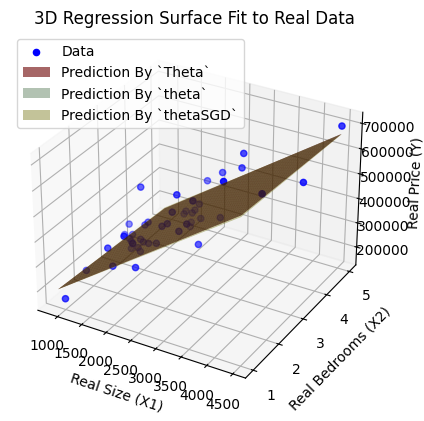

In [15]:
X_1 = data[["Size_sqft"]].values
X_2 = data[["Bedrooms"]].values
Y = data[["Price_USD"]].values

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_1, X_2, Y, c='blue', label='Data')

x1_range = np.linspace(X_1.min(), X_1.max(), 50)
x2_range = np.linspace(X_2.min(), X_2.max(), 50)
x1_mesh, x2_mesh = np.meshgrid(x1_range, x2_range)

x1_flat = x1_mesh.ravel()
x2_flat = x2_mesh.ravel()
X_surface = np.column_stack([ x1_flat, x2_flat])
Y_surface_Theta = inference.predict(X_surface,use_Theta=True, add_bias=True).reshape(x1_mesh.shape)
Y_surface_theta = inference.predict(X_surface,use_theta=True, add_bias=True).reshape(x1_mesh.shape)
Y_surface_thetaSGD = inference.predict(X_surface,use_thetaSGD=True, add_bias=True).reshape(x1_mesh.shape)

ax.plot_surface(x1_mesh, x2_mesh, Y_surface_Theta, color='red',
                alpha=0.6, label='Prediction By `Theta`')
ax.plot_surface(x1_mesh, x2_mesh, Y_surface_Theta, color='green',
                alpha=0.3, label='Prediction By `theta`')
ax.plot_surface(x1_mesh, x2_mesh, Y_surface_thetaSGD, color='yellow',
                alpha=0.4, label='Prediction By `thetaSGD`')
ax.set_xlabel('Real Size (X1)')
ax.set_ylabel('Real Bedrooms (X2)')
ax.set_zlabel('Real Price (Y)')
plt.title('3D Regression Surface Fit to Real Data')
plt.legend()
plt.show()

Using `theta` (Batch GD)
Using `Theta` (Normal Eq)
Using `thetaSGD` (SGD)


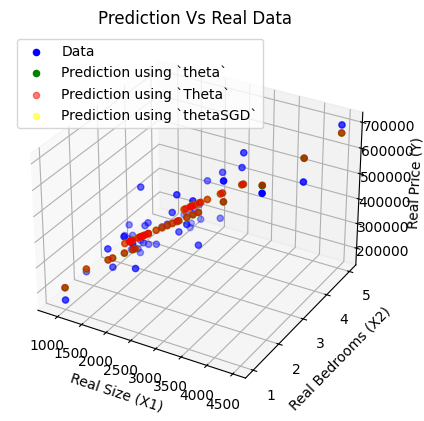

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_1, X_2, Y, c='blue', label='Data')

theta_pred = inference.predict(x_train,use_theta=True, add_bias=True)
Theta_pred = inference.predict(x_train,use_Theta=True, add_bias=True)
thataSGD_pred = inference.predict(x_train, use_thetaSGD=True, add_bias=True)
ax.scatter(X_1, X_2, theta_pred, label='Prediction using `theta`', c='green')
ax.scatter(X_1, X_2, Theta_pred, label='Prediction using `Theta`', c='red', alpha=0.5)
ax.scatter(X_1, X_2, thataSGD_pred, label='Prediction using `thetaSGD`', c='yellow', alpha=0.5)
ax.set_xlabel('Real Size (X1)')
ax.set_ylabel('Real Bedrooms (X2)')
ax.set_zlabel('Real Price (Y)')
plt.title('Prediction Vs Real Data')
plt.legend()
plt.show()
